In [1]:
import sys, os
sys.path.append("C:/users/kristijan/documents/projects/jhu1/")
sys.path.append("C:/users/kristijan/documents/projects/jhu1/data")
sys.path.append("C:/users/kristijan/documents/projects/jhu1/output")
os.chdir("C:/users/kristijan/documents/projects/jhu1/")
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
sns.set(font_scale=1.3)
from matplotlib import pyplot as plt
from stimuli import prefixes, prompts
import json

# Introduction

We are studying the functional properties of the memory systems allowing ANNs (Transformers and RNNs) to solve natural language tasks.  

Cognitive neuroscience provides us with two possible scenarios:  
- A) memory traces are **short lived** aking to the **working memory system** posited by Baddeley et al (i.e. isolated from long-term knowledge)  
- B) memory traces are **long-lived** and entangled/or interacting with long-term knowledge (e.g. **hippocampal/episodic system**)  

We study these dimensions of a working memory task:  
- **list length** (nr. of items to be remembered)  
- **prompt length** (prompt) length: number of items intervening between the remembered list and repeated exposure  
- **list composition** (list type): whether nouns in the list share semantic category (categorized or random)  
- **context (prompt) type** whether or not prompt is intact or scrambled (incongruent)  

Insofar as predictions are concerned, it seems the A) and B) should primarily differ in terms of the influence of semantic knowledge on performace:  
- A): shared semantic properties (of word lists, of prompts) lead to **improved performance** as short-lived memory traces are **refhreshed** (like rehearsal)  
- B): shared semantic properties (of word lists, of prompts) lead to **impaired performance** as similarity in long-lasting traces leads to **interference** (too many similar traces active  

(Not so sure about list length and other dimensions atm).  

## Loading in the data and some mimimal wrangling

In [2]:
# read in the outputs created in outputs4dataframe.py
gpt = pd.read_csv("./output/output_gpt2.csv", sep="\t", index_col=0)
rnn = pd.read_csv("./output/output_rnn.csv", sep="\t", index_col=0)

## Data checks

First, we check that all seems good on the input data side.

We will be interested in these variables:  
- `surp`: surprisal  
- `list_len`: length of the list  
- `prompt_len`: length of the prompt between two lists (n. tokens)  
- `list`: list composition (categorized or random)  
- `second_list`: whether the second list is repeated, permuted or an unrelated (control) list  
  

RNN output
(puncuation is removed):

In [3]:
rnn.head(5)

,word,sentid,corpuspos,marker,prompt_len,list_len,wlen,surp,hs,dHs,list,second_list,context,marker_pos,marker_pos_rel
0,before,0,0,0,8,3.0,6,10.156857,6.533242,0.000000,categorized,permute,intact,1,0
1,the,0,1,0,8,3.0,3,1.502160,5.209762,1.323480,categorized,permute,intact,2,1
2,meeting,0,2,0,8,3.0,7,8.726244,7.835398,-2.625636,categorized,permute,intact,3,2
4,<unk>,0,4,0,8,3.0,5,1.729451,4.781773,0.529446,categorized,permute,intact,4,3
5,wrote,0,5,0,8,3.0,5,6.610217,7.430719,-2.648947,categorized,permute,intact,5,4


GPT-2 output:

In [4]:
gpt.head(5)

,token,marker,positionID,surp,ispunct,prefix,prompt_len,list_len,sentid,second_list,list,context,sentpos,marker_pos,marker_pos_rel
0,Before,0,0,NaN,False,1,8,3,1,permute,categorized,scrambled,0,1,0
1,the,0,1,2.551027,False,1,8,3,1,permute,categorized,scrambled,1,2,1
2,meeting,0,2,5.753714,False,1,8,3,1,permute,categorized,scrambled,2,3,2
4,Mary,0,4,8.620794,False,1,8,3,1,permute,categorized,scrambled,3,4,3
5,wrote,0,5,6.034746,False,1,8,3,1,permute,categorized,scrambled,4,5,4


## Checking the stimuli and prompt manipulation

First, let's check the input strings for the congruent scenario:

In [5]:
stimulus_id = 92 # let's pick a trial
selection = ((gpt.sentid==stimulus_id) & (gpt.second_list=="permute") & (gpt.list=="random") & (gpt.context=="intact"))
for i in range(4):
    print("{}: ".format(i) + " ".join(gpt.loc[(gpt.marker == i) & selection].token.tolist()).strip())

0: Before  the  meeting  Mary  wrote  down  the  following  list  of  words
1: farmer  contest  outline  success  orange
2: After  the  meeting  Mary  went  for  a  walk  It  was  a  busy  day  and  she  needed  a  break  Outside  was  really  beautiful  and  warm  and  the  flowers  in  the  park  were  blo oming  When  she  got  back  she  read  the  list  again
3: success  outline  contest  farmer  orange


So the prompt under 2 looks fine.

We now do the same but we select rows marked as incongruent prompt and string under 2 should be permuted.
The two lists are the same, only the second one is permuted.

In [6]:
selection = ((gpt.sentid==stimulus_id) & (gpt.second_list=="permute") & (gpt.list=="random") & (gpt.context=="scrambled"))
for i in range(4):
    print("{}: ".format(i) + " ".join(gpt.loc[(gpt.marker == i) & selection].token.tolist()).strip())

0: Before  the  meeting  Mary  wrote  down  the  following  list  of  words
1: farmer  contest  outline  success  orange
2: the  back  in  for  and  were  a  When  she  walk  was  meeting  Outside  break  the  got  warm  went  and  After  Mary  the  read  list  park  beautiful  again  really  a  a  needed  It  busy  was  she  and  she  day  the  flowers  blo oming
3: success  outline  contest  farmer  orange


# Results

## RNN

We now explore how surprisal fluctuates over token positions (averaged over 20 word lists, per position).  
We put token position on x-axes and surprisal on y.  
We color code prompt length.  
Prompt type -- congruent or incongruent -- is show in top and bottom rows, respectively.  
List type -- repeated, permuted or control -- is displayed from left to right column-wise.  

Points mark average surprisal over 20 tokens, bars denote 95% confidence intervals (bootstrapped by sampling with replacement 1000 times).

We start with RNN. We make 3 plots (list lengths of 10, 5, and 3).

We see there is little variability going from left to right column-wise meaning that in this paradigm we cannot detect RNN sensitivity to list identity or word order.  
On the other hand, we do see that bottom row has a sort of a surprisal jump for the lightest color (max prompt length of 400 tokens).  
This suggests that increasing once we interfere with 400 permuted tokens, the RNN was not expecting a content noun after a colon. The jump is rather non-linear and it fades after one token or so.  

In [7]:
# define a wrapper function
def make_plot(data_frame, list_type, title, palette="flare"):
    
    sns.set_style("white")
    p = sns.catplot(data=data_frame, kind="point", x="marker_pos_rel", y="surp", hue="prompt_len", col="second_list", row="context",
                    estimator=np.mean, ci=95.0,
                    col_order=["repeat", "permute", "control"],
                    row_order=["intact", "scrambled"],
                    palette=palette)
    p.fig.set_size_inches(18,7)  
    p.fig.subplots_adjust(top=0.85)
    p.fig.suptitle(title)
    p.set_axis_labels( "token position in list (index)" , "mean surprisal\n(+/-95 ci)")
    p._legend.set_title("prompt length\n(n. tokens)")
    p.set_titles("prompt = {row_name} | list = {col_name}")
    p.despine(left=True);

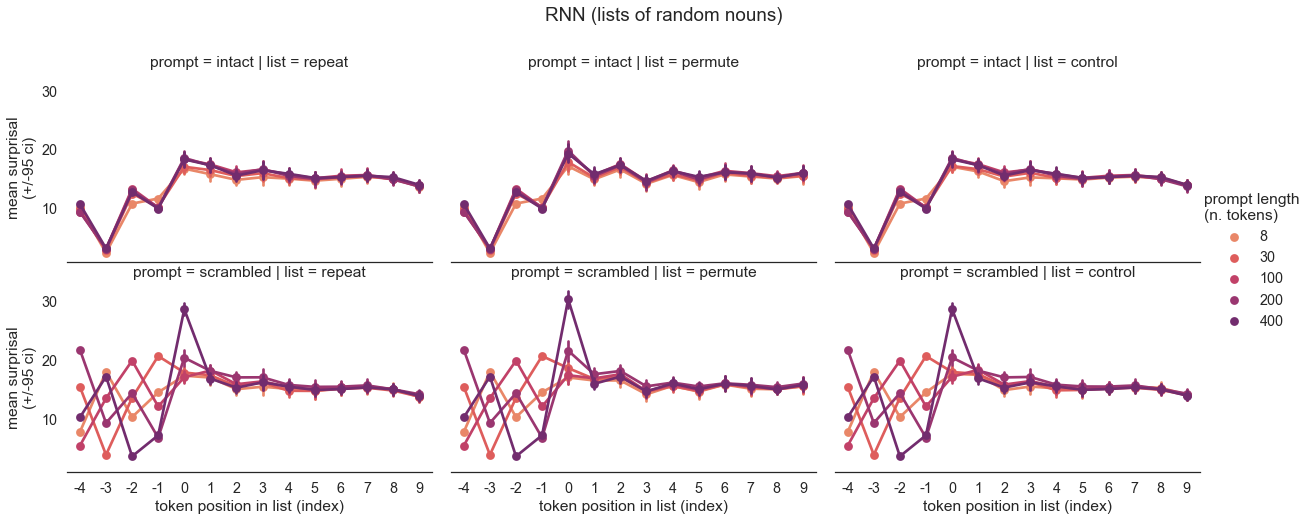

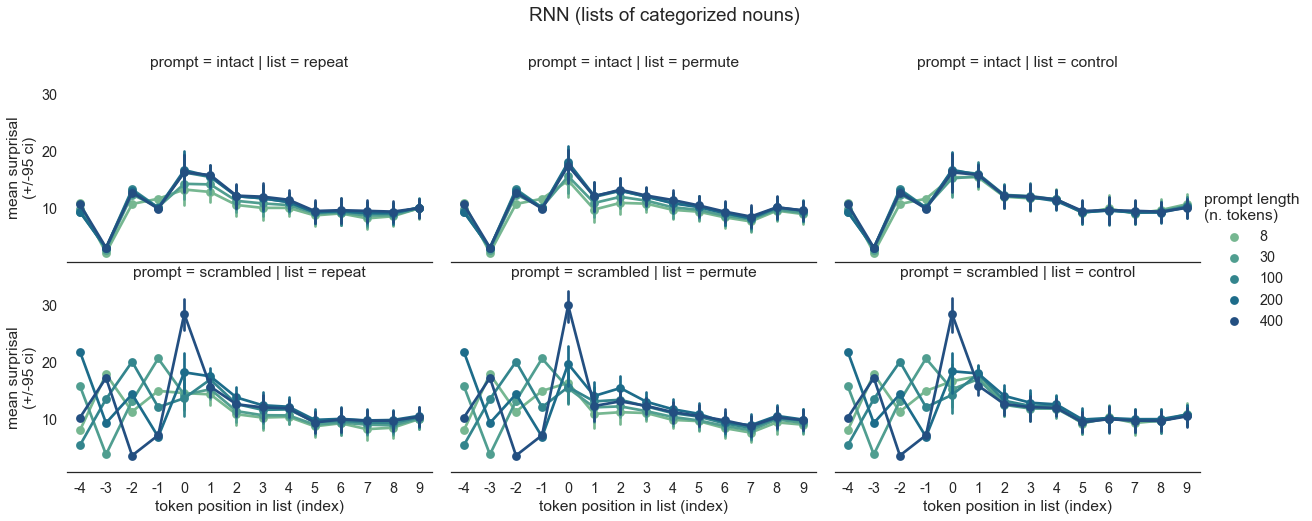

In [8]:
cmap = {"random": "flare", "categorized": "crest"}
for c in cmap.keys():
    for l in [10]:
        data=None
        list_len=l
        list_type = c
        selection = (rnn.marker.isin([2, 3])) & (rnn.marker_pos_rel.isin(list(range(-4, l)))) & \
                    (rnn.list_len==list_len) & (rnn.list==list_type)
        data = rnn.loc[selection].copy()  # list of len 10
        make_plot(data, list_type, title="RNN (lists of {} nouns)".format(list_type), palette=cmap[c])

## GPT-2

We repeat the same for the gpt-2 output.

As was clear before, GPT-2 is much more sensitive to list identity

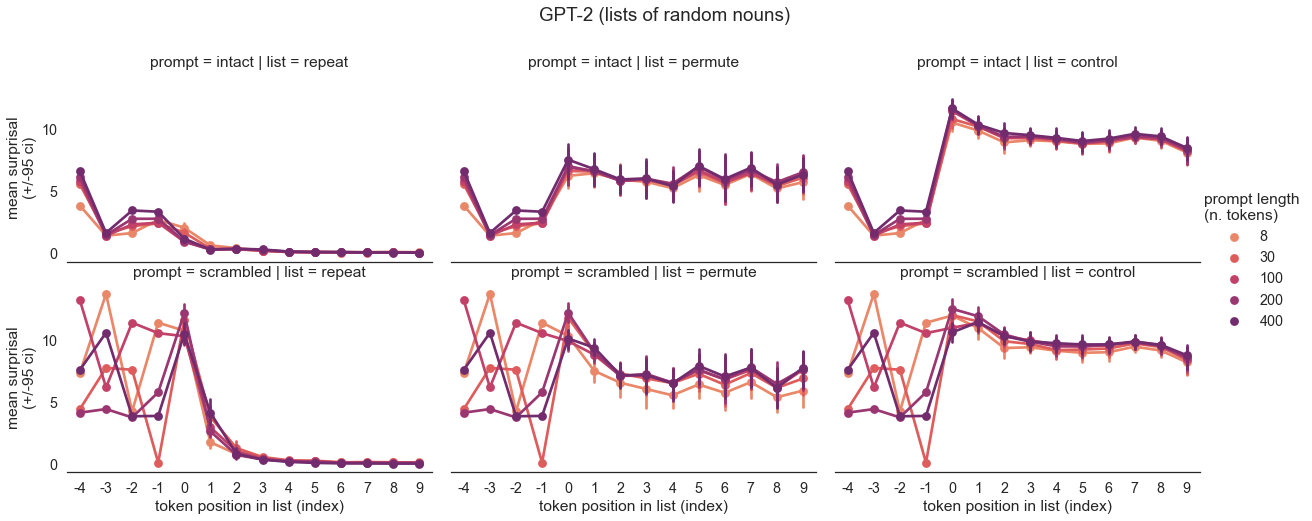

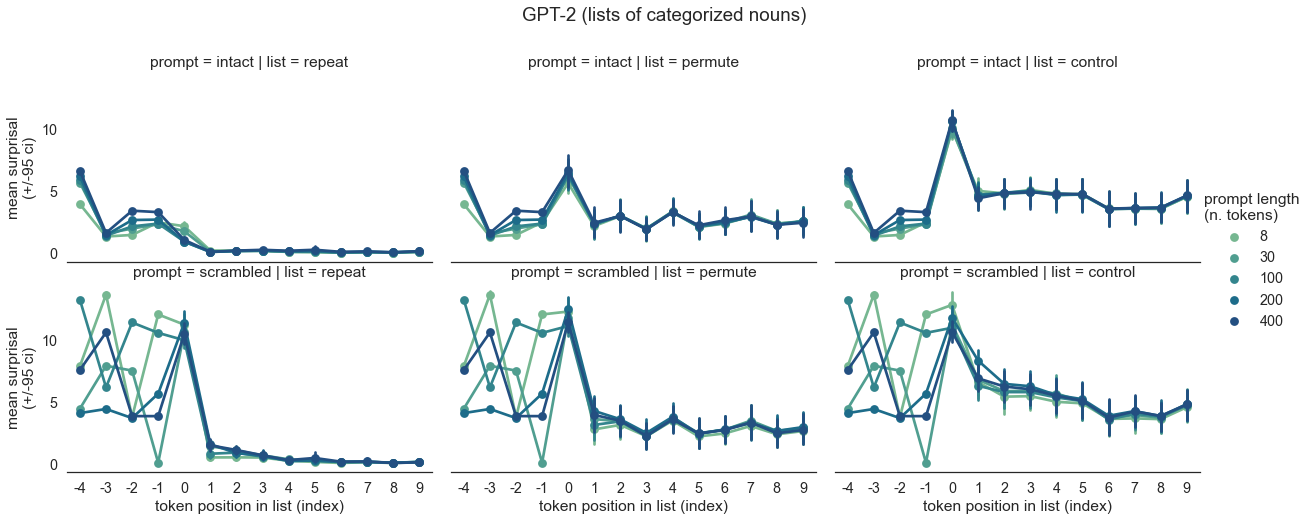

In [9]:
cmap = {"random": "flare", "categorized": "crest"}
for c in cmap.keys():
    for l in [10]:
        data=None
        list_len=l
        list_type = c
        selection = (gpt.marker.isin([2, 3])) & (gpt.marker_pos_rel.isin(list(range(-4, l)))) & \
                    (gpt.list_len==list_len) & (gpt.list==list_type)
        data = gpt.loc[selection].copy()  # list of len 10
        make_plot(data, list_type, title="GPT-2 (lists of {} nouns)".format(list_type), palette=cmap[c]) # list of len 10

# Interim conclusion

- GPT-2 stores list identity (flooring in list repeat condition) and word order (effect of repeating and permuting the list)  
- cannot claim similar for RNN (either we cannot detect or there is no effect)   
- if anything, GPT-2 seems more similar to a "classical working memory system" because, so far, shared semantic similarities (list repetition, prompt congruence) lead to facilitation (as inferred from reduced surprisal levels) on processing.  
- if context (prompt) is incongruent and > 400 tokens length, the structure of context matters to RNN it seems, so it is not so idle after all   
- so far, it is hard to say how number of items impacts the memory system  